In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import MinMaxScaler 
from collections import Counter
from scipy import cluster 

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


<p>1. Select a sample of the data.</p>

In [2]:
limit_rows = 2000000
df = pd.read_csv('../Data/train_ver2_clean2.csv', nrows=limit_rows)
unique_ids = pd.Series(df["ncodpers"].unique())
limit_people = 1e5
unique_ids_sample = unique_ids.sample(n=limit_people)
df  = df[df.ncodpers.isin(unique_ids_sample)]

/home/pablo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pablo/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2572: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


<p>2. Select only the first month of the data.</p>

In [3]:
df=df[df['fecha_dato']=='2015-01-28']

<p>3. Firt, we try to find some relations between the 'nomprov' and 'renta' client features and his products.</p>
<p>3.1. Save in a new DataFrame the products, 'renta' and 'nomprov' columns</p>

In [4]:
products_columns = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
products_renta_prov_columns = np.append(products_columns, ['nomprov','renta'])
df_prov_renta = df.ix[:, products_renta_prov_columns]

<p> 3.2. We select the provinces of Ciudad Real, Madrid, Badajoz and Barcelona.</p>

In [5]:
columns_to_delete = ['nomprov', 'renta']

df_cr = df_prov_renta[df_prov_renta['nomprov'] == 'CIUDAD REAL']
df_madrid = df_prov_renta[df_prov_renta['nomprov'] == 'MADRID']
df_badajoz = df_prov_renta[df_prov_renta['nomprov'] == 'BADAJOZ']
df_barcelona = df_prov_renta[df_prov_renta['nomprov'] == 'BARCELONA']

df_cr_prov = df_cr.drop(columns_to_delete, axis = 1)
df_madrid_prov = df_madrid.drop(columns_to_delete, axis = 1)
df_badajoz_prov = df_badajoz.drop(columns_to_delete, axis = 1)
df_barcelona_prov = df_barcelona.drop(columns_to_delete, axis = 1)

samples_prov = [df_cr_prov, df_madrid_prov, df_badajoz_prov, df_barcelona_prov]
samples_prov_names = ['Ciudad Real', 'Madrid', 'Badajoz', 'Barcelona']

3.3. First, we do a k-means for calculate the silhouette. Then, we do a hierarchical clustering and plot the dendograms.

Silhouette[Ciudad Real]: 0.856234679808
Silhouette[Madrid]: 0.784199311609
Silhouette[Badajoz]: 0.918100804974
Silhouette[Barcelona]: 0.851472904613


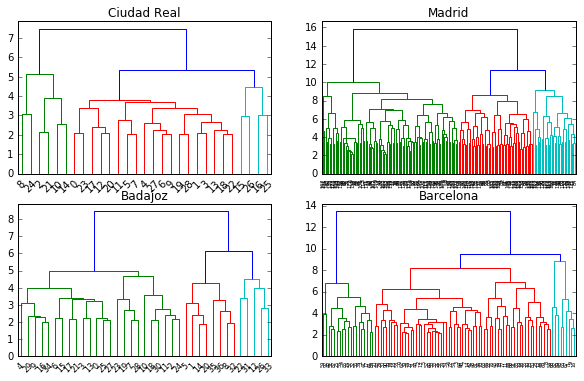

In [6]:
for i, df_prov in enumerate(samples_prov):
    n_clusters = int(np.sqrt(df_prov.shape[0]))
    km = KMeans(n_clusters, init = 'k-means++', max_iter=300, tol=1e-05)
    labels = km.fit_predict(df_prov)
    
    df_prov['cluster'] = labels
    df_prov_grouped = df_prov.groupby(by=['cluster']).mean()
    
    df_prov_sample = df_prov.sample(800)
    silhouette = metrics.silhouette_score(df_prov_sample[products_columns], df_prov_sample['cluster'])
    
    print 'Silhouette[{0}]: {1}'.format(samples_prov_names[i], silhouette)
    
    dist = DistanceMetric.get_metric('euclidean')
    matsim = dist.pairwise(df_prov_grouped)
    clusters = cluster.hierarchy.linkage(matsim, method='complete')
    
    plt.subplot(2,2,i+1)
    plt.title(samples_prov_names[i])
    cluster.hierarchy.dendrogram(clusters)

plt.show()

As we can see, the silhouettes are high and the leafs of the dendogram are hihg too, so we can conclude there are not relation between the 'nomprov' feature and the products of one client.

<p>4. Now, we find some relation between the 'renta' feature and the products of the clients.</p> 

<p>4.1. Scale the 'renta' per province.</p> 

In [7]:
min_max_scaler = MinMaxScaler()
for prov in df['nomprov'].unique():
    df_prov_renta.ix[df_prov_renta.nomprov == prov, 'renta'] = min_max_scaler.fit_transform(df_prov_renta.ix[df_prov_renta.nomprov == prov, 'renta'].reshape(-1, 1))

4.2. Split the 'renta' in three groups with a K-means.

In [8]:
renta_groups = 3
km = KMeans(renta_groups, init = 'k-means++', max_iter=300, tol=1e-06)
labels = km.fit_predict(df_prov_renta['renta'].reshape(-1, 1))
df_prov_renta['renta'] = labels

4.3. Select the province of Madrid

In [9]:
df_madrid = df_prov_renta.loc[df_prov_renta['nomprov'] == 'MADRID', products_columns]
df_madrid_r_0 = df_prov_renta[df_prov_renta['renta'] == 0].drop(['renta', 'nomprov'], axis=1)

df_madrid = df_prov_renta.loc[df_prov_renta['nomprov'] == 'MADRID', products_columns]
df_madrid_r_1 = df_prov_renta[df_prov_renta['renta'] == 1].drop(['renta', 'nomprov'], axis=1)

df_madrid = df_prov_renta.loc[df_prov_renta['nomprov'] == 'MADRID', products_columns]
df_madrid_r_2 = df_prov_renta[df['renta'] == 2].drop(['renta', 'nomprov'], axis=1)

rentas_madrid = [df_madrid_r_0, df_madrid_r_1, df_madrid_r_2]

4.4. First, we do a k-means for calculate the silhouette. Then, we do a hierarchical clustering and plot the dendograms.

Silhouette [0]: 0.841327281898
Silhouette [1]: 0.885805243722


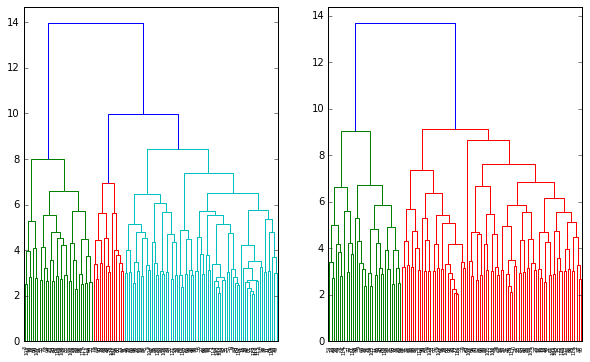

In [10]:
for i, df_madrid in enumerate(rentas_madrid):
    if df_madrid.shape[0] > 0:
        if df_madrid.shape[0] > 15000:
            df_madrid = df_madrid.sample(15000)

        n_clusters = int(np.sqrt(df_madrid.shape[0]))
        km = KMeans(n_clusters, init = 'k-means++', max_iter=300, tol=1e-05)
        labels = km.fit_predict(df_madrid)

        df_madrid['cluster'] = labels
        df_madrid_grouped = df_madrid.groupby(by=['cluster']).mean()

        df_madrid_sample = df_madrid.sample(800)
        silhouette = metrics.silhouette_score(df_madrid_sample[products_columns], df_madrid_sample['cluster'])
        print 'Silhouette [{0}]: {1}'.format(i, silhouette)
        
        dist = DistanceMetric.get_metric('euclidean')
        matsim = dist.pairwise(df_madrid_grouped)
        clusters = cluster.hierarchy.linkage(matsim, method='complete')

        plt.subplot(1,2,i+1)
        cluster.hierarchy.dendrogram(clusters)

plt.show()

As we can see, the silhouettes are high and the leafs of the dendogram are hihg too, so we can conclude there are not relation between the 'nomprov' feature and the products of one client.

<p>5. Now, we see if the young people in the dataset have the same products.</p>

<p>5.1. Select the minor clients.</p>

In [11]:
df_jovenes = df[(df['age'] >=1) & (df['age'] <= 17)].drop('age', axis = 1)
df_jovenes = df_jovenes[products_columns]

<p>5.2. Use a K-means algorithm. </p>

In [12]:
n_clusters = int(np.sqrt(df_jovenes.shape[0]))
km = KMeans(n_clusters, init = 'random', max_iter=300, tol=1e-05)
labels = km.fit_predict(df_jovenes)

df_jovenes['cluster'] = labels
df_jovenes_grouped = df_jovenes.groupby(by=['cluster']).mean()

print 'Sqrt of the number of minor clients: {0}'.format(n_clusters)
print 'Number of clusters obtained by k-means: {0}'.format(df_jovenes_grouped.shape[0])

df_jovenes_sample = df_jovenes.sample(800)
silhouette = metrics.silhouette_score(df_jovenes_sample[products_columns], df_jovenes_sample['cluster'])
print 'Silhouette [jovenes]: {0}'.format(silhouette)

Sqrt of the number of minor clients: 31
Number of clusters obtained by k-means: 6
Silhouette [jovenes]: 0.99875


5.3. Hierarchical clustering

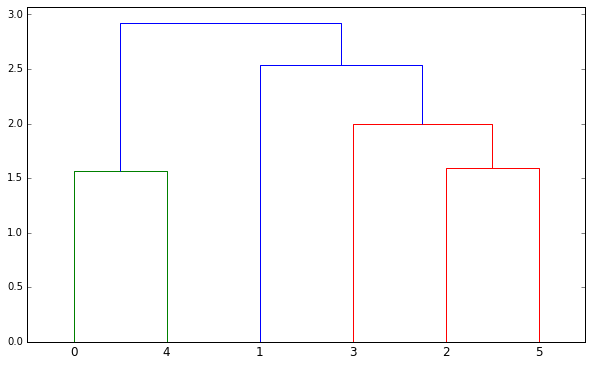

In [13]:
dist = DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(df_jovenes_grouped)
clusters = cluster.hierarchy.linkage(matsim, method='complete')
cluster.hierarchy.dendrogram(clusters)

plt.title = samples_prov_names[i]
plt.show()

5.4. Although the silhouette is high, we can see that the number of clusteris obtained is much lower than expected. So, we count the elements in each cluster.

In [14]:
Counter(labels)

Counter({0: 1, 2: 1, 3: 4, 5: 2, 7: 3, 17: 951})

5.5. We can conclude the minor clients could have the same conduct in the purchase of products because the majority belongs to the same cluster.